In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
print(tf.__version__)

1.3.0


In [2]:
import dcgan_helper

data_dir = './data'
dcgan_helper.download_extract('mnist', data_dir)

Found mnist Data


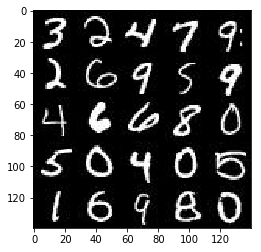

In [3]:
show_n_images = 25
mnist_images = dcgan_helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
plt.imshow(dcgan_helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [4]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 shape=(None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # image: 28x28x[1|3]
        x = tf.layers.conv2d(images, 64, kernel_size=5, strides=2, 
                             padding='same', activation=None)
        x = tf.maximum(alpha * x, x)
        # 14x14x64 now
        #print(x.shape)
        
        x = tf.layers.conv2d(x, 128, kernel_size=5, strides=2, 
                             padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 7x7x128 now
        #print(x.shape)
        
        x = tf.layers.conv2d(x, 256, kernel_size=5, strides=2, 
                             padding='valid', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 2x2x512 now
        #print(x.shape)
        
        flat = tf.reshape(x, [-1, 2*2*512])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 2*2*512, activation=None,
                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x = tf.reshape(x, shape=[-1,2,2,512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.relu(x)
        # 4x4x256 now
        #print("x: ", x.shape)
        
        conv1 = tf.layers.conv2d_transpose(
            x, 256, kernel_size=5, strides=2, padding='valid', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.nn.relu(conv1)
        # 7x7x128 now
        #print("conv1: ", conv1.shape)
        
        conv2 = tf.layers.conv2d_transpose(
            conv1, 128, kernel_size=5, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.nn.relu(conv2)
        # 14x14x64 now
        #print("conv2: ", conv2.shape)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(
            conv2, out_channel_dim, kernel_size=5, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3 now
        #print("logits: ", logits.shape)
        
        out = tf.tanh(logits)
        
    return out

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    '''
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    '''
    
    eps = sys.float_info.epsilon
    g_loss = tf.reduce_mean(-tf.log(d_model_fake + eps))
    d_loss = tf.reduce_mean(-tf.log(d_model_real + eps) - tf.log(1 - d_model_fake + eps))

    return d_loss, g_loss

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [9]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = dcgan_helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 300 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

(60000, 28, 28, 1)
Epoch 1/10... Discriminator Loss: 0.2971... Generator Loss: 1.8510
Epoch 1/10... Discriminator Loss: 0.1981... Generator Loss: 4.5288
Epoch 1/10... Discriminator Loss: 0.4409... Generator Loss: 1.3435


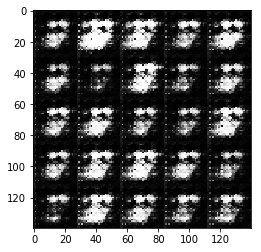

Epoch 1/10... Discriminator Loss: 0.1487... Generator Loss: 2.8692
Epoch 2/10... Discriminator Loss: 0.1741... Generator Loss: 2.4366
Epoch 2/10... Discriminator Loss: 0.6122... Generator Loss: 1.3568


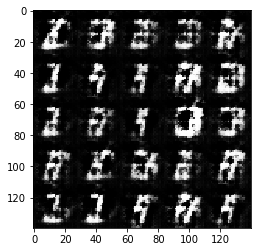

Epoch 2/10... Discriminator Loss: 0.3351... Generator Loss: 3.9874
Epoch 2/10... Discriminator Loss: 0.4777... Generator Loss: 1.6692
Epoch 2/10... Discriminator Loss: 0.4787... Generator Loss: 1.6272


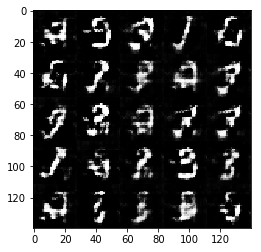

Epoch 3/10... Discriminator Loss: 0.3816... Generator Loss: 1.9233
Epoch 3/10... Discriminator Loss: 0.5099... Generator Loss: 1.6660
Epoch 3/10... Discriminator Loss: 0.4906... Generator Loss: 1.6020


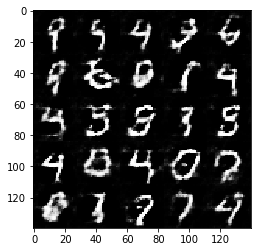

Epoch 3/10... Discriminator Loss: 0.6235... Generator Loss: 1.2054
Epoch 3/10... Discriminator Loss: 0.5836... Generator Loss: 1.7660
Epoch 4/10... Discriminator Loss: 0.6830... Generator Loss: 1.2921


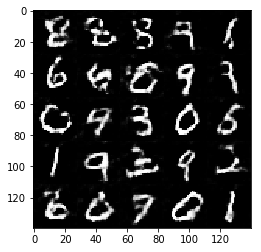

Epoch 4/10... Discriminator Loss: 1.1614... Generator Loss: 0.5114
Epoch 4/10... Discriminator Loss: 0.8436... Generator Loss: 0.7196
Epoch 4/10... Discriminator Loss: 0.6963... Generator Loss: 1.2471


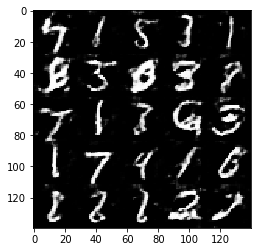

Epoch 5/10... Discriminator Loss: 0.7184... Generator Loss: 1.2308
Epoch 5/10... Discriminator Loss: 0.6173... Generator Loss: 1.3552
Epoch 5/10... Discriminator Loss: 0.7486... Generator Loss: 1.1653


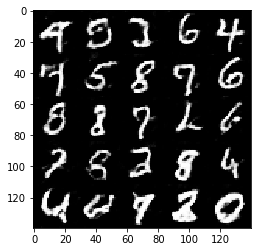

Epoch 5/10... Discriminator Loss: 0.7975... Generator Loss: 1.0785
Epoch 5/10... Discriminator Loss: 0.8196... Generator Loss: 1.0573
Epoch 6/10... Discriminator Loss: 0.9242... Generator Loss: 1.7359


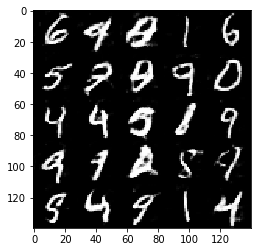

Epoch 6/10... Discriminator Loss: 0.9208... Generator Loss: 0.7843
Epoch 6/10... Discriminator Loss: 0.9051... Generator Loss: 1.0333
Epoch 6/10... Discriminator Loss: 1.0983... Generator Loss: 0.5548


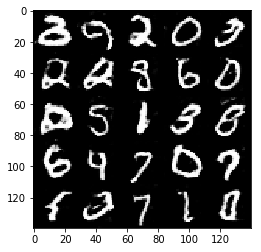

Epoch 6/10... Discriminator Loss: 0.7581... Generator Loss: 1.3683
Epoch 7/10... Discriminator Loss: 0.7471... Generator Loss: 1.0821
Epoch 7/10... Discriminator Loss: 0.8014... Generator Loss: 1.6252


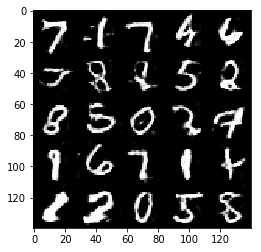

Epoch 7/10... Discriminator Loss: 0.9509... Generator Loss: 1.9562
Epoch 7/10... Discriminator Loss: 1.1674... Generator Loss: 0.5380
Epoch 8/10... Discriminator Loss: 0.8643... Generator Loss: 0.9459


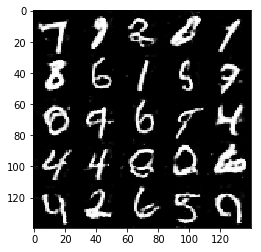

Epoch 8/10... Discriminator Loss: 1.1521... Generator Loss: 0.5084
Epoch 8/10... Discriminator Loss: 0.7337... Generator Loss: 1.0557
Epoch 8/10... Discriminator Loss: 0.7029... Generator Loss: 1.3763


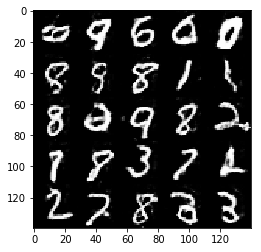

Epoch 8/10... Discriminator Loss: 0.9586... Generator Loss: 2.2795
Epoch 9/10... Discriminator Loss: 0.9913... Generator Loss: 0.6159
Epoch 9/10... Discriminator Loss: 0.7909... Generator Loss: 0.8355


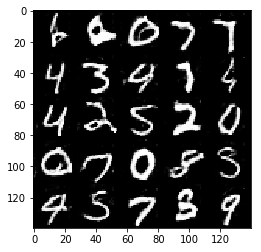

Epoch 9/10... Discriminator Loss: 0.8385... Generator Loss: 0.7524
Epoch 9/10... Discriminator Loss: 0.8889... Generator Loss: 0.7708
Epoch 9/10... Discriminator Loss: 1.1507... Generator Loss: 0.5094


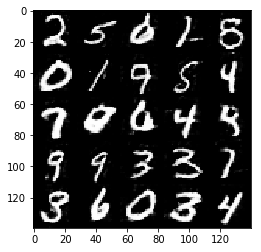

Epoch 10/10... Discriminator Loss: 0.7525... Generator Loss: 1.2511
Epoch 10/10... Discriminator Loss: 0.7173... Generator Loss: 1.1211
Epoch 10/10... Discriminator Loss: 0.8189... Generator Loss: 0.7800


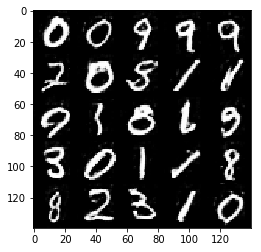

Epoch 10/10... Discriminator Loss: 0.9660... Generator Loss: 0.7607


In [11]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 10

mnist_dataset = dcgan_helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)